In [1]:
import numpy as np
from astropy.io import fits
import requests
from astroquery.mast import Catalogs
import zipfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import lightkurve
%matplotlib inline
urlroot = "https://mast.stsci.edu/tesscut/api/v0.1"
#Original Code from: https://github.com/KeplerGO/lightkurve/issues/14
from lightkurve import search_targetpixelfile, TessTargetPixelFile
from astroquery.skyview import SkyView
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize,PercentileInterval,SqrtStretch

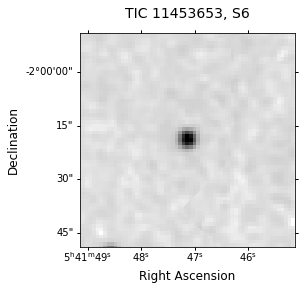

In [2]:
#What to inspect?
tic = 11453653
sector = 6
tpf = TessTargetPixelFile("https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=85.446434&dec=-2.005281&y=15&x=10&units=px&sector=6")
#tpf = search_targetpixelfile(200516544, sector=6).download()

#Requires some wcs projection for the axis
#I get one from the image header that I want to plot pixel locations over
c = SkyCoord(ra=tpf.ra*u.degree, dec=tpf.dec*u.degree, frame='icrs')
images = SkyView.get_images(position=c, survey=['2MASS-J'], radius=1.*u.arcmin)
wcs = WCS(images[0][0].header)

#Get median RA,Dec for each pixel
pixra = np.median(tpf.get_coordinates()[0],axis=0)
pixdec = np.median(tpf.get_coordinates()[1],axis=0)

#Convert RA,DEC to pixel coordinates in image frame
pixels = wcs.wcs_world2pix(pixra*u.degree,pixdec*u.degree,1)
#Reshape for plotting
xy = np.reshape(pixels,(2,pixels[0].size)).T
npixels = len(xy)

#Spacing between pixels is also spacing between corners of pixels
dx = np.median(np.diff(pixels)[0])
dy = np.median(np.diff(pixels)[1])

#Define locations of corners relative to pixel centers
corners = np.array([[1.,1.],[1.,-1.],[-1.,-1.],[-1.,1],[1.,1.]])
offsetmatrix = np.array(((dx,-dy), (dy, dx)))/2.
#There must be a more elegant way to do this...
for i in range(len(corners)):
    corners[i] = np.cross(offsetmatrix,corners[i])

#Which pixels have data or are in mask
# 0 = no data; 1 = data, 2 = mask
d = np.zeros(npixels,dtype=int)
d[np.isfinite(tpf.flux[0]).flatten()] += 1
d[tpf.pipeline_mask.flatten()] += 1
colors = ['None','lightblue','red']
lws = [0,1,2]
zorders = [0,1,2]

#Plot reference image
f = plt.figure(figsize=(4.2,4))
ax = plt.subplot(projection=wcs)
norm = ImageNormalize(images[0][0].data, interval=PercentileInterval(99.9),
                      stretch=SqrtStretch())
ax.imshow(images[0][0].data,origin='lower',norm=norm,cmap='gray_r')

#Plot boundaries of each pixel
#for i in range(npixels):
    #ccoords = xy[i]+corners
    #ax.plot(ccoords[:,0],ccoords[:,1],c=colors[d[i]],lw=lws[d[i]],zorder=zorders[d[i]])

ax.set_title('TIC '+str(tic)+', S'+str(sector),size=14,pad=15)
ax.set_xlabel('Right Ascension',size=12)
ax.set_ylabel('Declination',size=12)
ax.set_aspect(1)
plt.tight_layout(rect=[.22,-.3,1,1.3]) #matplotlib problem
plt.show()

In [3]:
ticid = 11453653
starName = "TIC " + str(ticid)
radSearch = 5 / 60 # radius in degrees
catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
Ra = catalogData[0]['ra']
Dec = catalogData[0]['dec']

In [4]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 14
# Make it a list of Ra, Dec pairs of the bright ones. So this is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )

In [5]:
url = urlroot + "/sector"

myparams = {"ra":Ra, "dec":Dec, "radius":"0m"}

requestData = requests.get(url = url, params = myparams)

print(requestData.headers.get('content-type'))

myparams = {"ra":Ra, "dec":Dec, "x":35, "y":45, 
           "units":"px", "sector":"All"}

url = urlroot + "/astrocut"

r = requests.get(url = url, params = myparams)

print(r)
print(r.headers.get('content-type'))

application/json; charset=UTF-8
<Response [200]>
application/zip


In [6]:
sectors = requestData.json()['results']

In [7]:
open('astrocut.zip', 'wb').write(r.content)
zipRef = zipfile.ZipFile('astrocut.zip','r')
zipRef.extractall('.')
zipRef.close()
# Get list of cuotut names
cutoutnames = zipRef.namelist()
file1 = cutoutnames[0]
hdu1 = fits.open(file1)

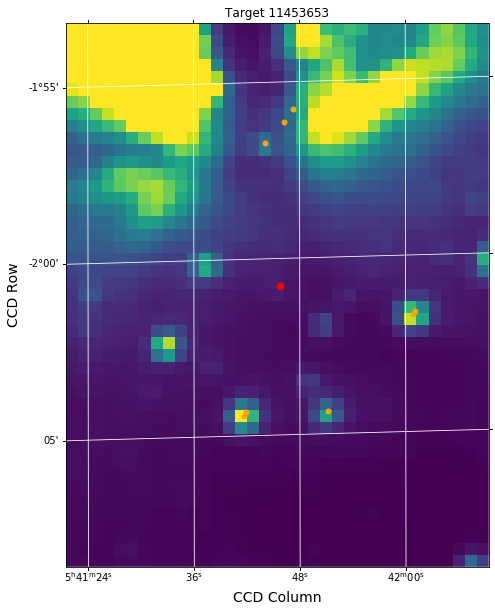

In [8]:
firstImage = hdu1[1].data['FLUX'][0]
wcs = WCS(hdu1[2].header)
fig = plt.figure(figsize = (10,10))
fig.add_subplot(111, projection = wcs)
plt.imshow(firstImage, origin = 'lower', cmap = plt.cm.viridis, vmax = np.percentile(firstImage,92),\
           vmin = np.percentile(firstImage,5))
plt.xlabel('CCD Column', fontsize = 14)
plt.ylabel('CCD Row', fontsize = 14)
plt.grid(axis = 'both', color = 'white', ls = 'solid')
starLoc = wcs.all_world2pix([[Ra,Dec]],0)  #Second is origin
plt.scatter(starLoc[0,0], starLoc[0,1], s = 45, color = 'red')
# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:], 0)
plt.scatter(nearbyLoc[1:,0], nearbyLoc[1:,1], s = 25, color = 'orange')
plt.title("Target "+ str(ticid))
plt.show()

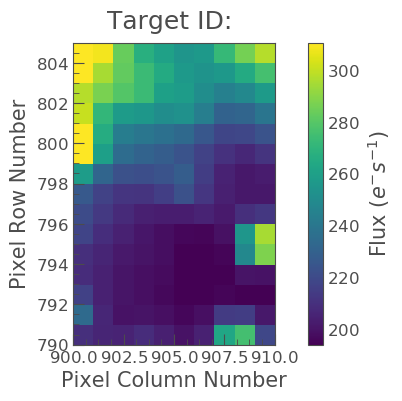

In [9]:
tpf = TessTargetPixelFile("https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=85.446434&dec=-2.005281&y=15&x=10&units=px&sector=6")
tpf.plot()

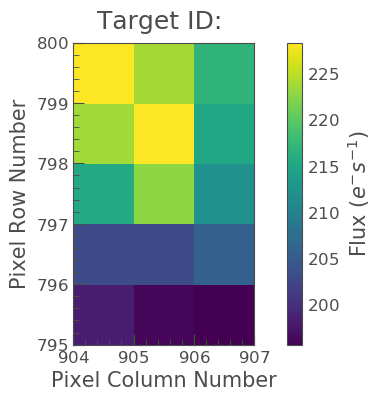

In [13]:
tpf_zoom = TessTargetPixelFile("https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=85.446434&dec=-2.005281&y=5&x=3&units=px&sector=6")
tpf_zoom.plot()

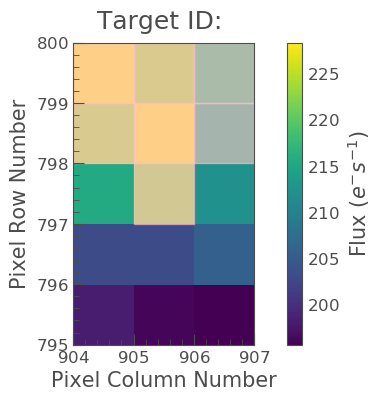

In [18]:
#This code is used to create a new aperture. Please note that this code is from Lightkurve Tutorials. 
import numpy as np
# Create a median image of the source over time
median_image = np.nanmedian(tpf_zoom.flux, axis=0)
# Select pixels which are brighter than the 86th percentile of the median image
aperture_mask = median_image > np.nanpercentile(median_image, 50)
# Plot that aperture
tpf_zoom.plot(aperture_mask=aperture_mask);

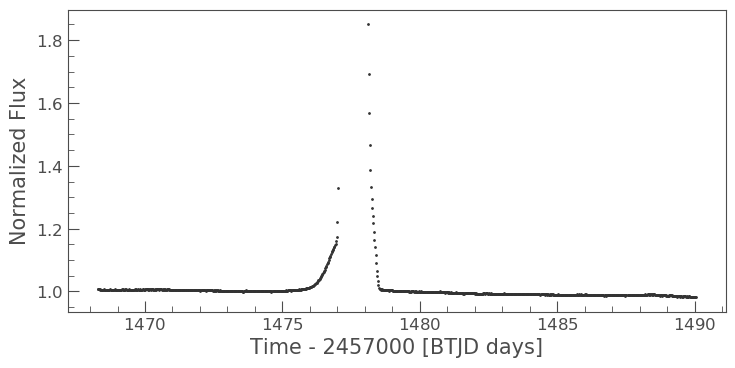

In [19]:
lc = tpf_zoom.to_lightcurve(aperture_mask=aperture_mask)
lc.scatter()

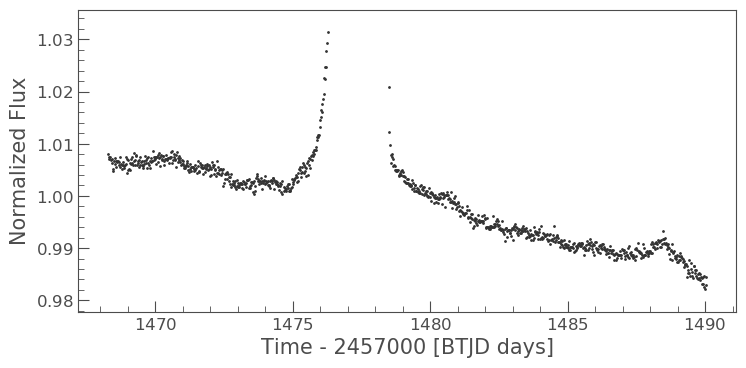

In [20]:
lc.remove_nans().remove_outliers(sigma=4).scatter()